# **Телекоммуникации: отток клиентов**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).  

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# **Предоставленные заказчиком данные**

4 таблицы с данными пользователей оператора связи, объединенные по ID пользователя (столбец customerID):  
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

# Цель проекта

Целью проекта является разработка модели классификации с гиперпараметрами, отвечающие требованию по метрикам качества заказчика, для прогноза оттока клиентов.

## Исследование предоставленных данных

На данном этапе я посмотрю, что из себя представляют данные, чтобы затем конкретизовать задачи. 

Прежде, чем начать исследование, следует импортировать необходимые библиотеки

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

!pip install catboost
from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier
!pip install -U scikit-learn

Далее я объявлю константу для всего проекта:

In [2]:
SEED = 280823

Далее следует открыть каждый из предоставленных датасетов и отдельно их изучить. Датасеты следует открыть как локально, так и через ядро ЯП.

### Информация о договоре

In [3]:
way_1 = '/Users/anastasiaklubkova/Downloads/contract_new.csv'
way_2 = '/datasets/contract_new.csv'

In [4]:
if os.path.exists(way_1):
    contract = pd.read_csv(way_1)
    print('Открыто локально')
elif os.path.exists(way_2):
    contract = pd.read_csv(way_2)
    print('Открыто через ЯП')
else:
    print('Что-то пошло не так')

Открыто через ЯП


In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
contract.duplicated().sum()

0

In [8]:
contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

### Персональные данные клиента

In [9]:
way_1 = '/Users/anastasiaklubkova/Downloads/personal_new.csv'
way_2 = '/datasets/personal_new.csv'

In [10]:
if os.path.exists(way_1):
    personal = pd.read_csv(way_1)
    print('Открыто локально')
elif os.path.exists(way_2):
    personal = pd.read_csv(way_2)
    print('Открыто через ЯП')
else:
    print('Что-то пошло не так')

Открыто через ЯП


In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal.duplicated().sum()

0

In [14]:
personal['SeniorCitizen'].unique()

array([0, 1])

### Информация об интернет-услугах

In [15]:
way_1 = '/Users/anastasiaklubkova/Downloads/internet_new.csv'
way_2 = '/datasets/internet_new.csv'

In [16]:
if os.path.exists(way_1):
    internet = pd.read_csv(way_1)
    print('Открыто локально')
elif os.path.exists(way_2):
    internet = pd.read_csv(way_2)
    print('Открыто через ЯП')
else:
    print('Что-то пошло не так')

Открыто через ЯП


In [17]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
internet.duplicated().sum()

0

### Информация об услугах телефонии

In [20]:
way_1 = '/Users/anastasiaklubkova/Downloads/phone_new.csv'
way_2 = '/datasets/phone_new.csv'

In [21]:
if os.path.exists(way_1):
    phone = pd.read_csv(way_1)
    print('Открыто локально')
elif os.path.exists(way_2):
    phone = pd.read_csv(way_2)
    print('Открыто через ЯП')
else:
    print('Что-то пошло не так')

Открыто через ЯП


In [22]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [23]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
phone.duplicated().sum()

0

In [25]:
con = list(contract['customerID'])
per = list(personal['customerID'])
net = list(internet['customerID'])
phon = list(phone['customerID'])

In [26]:
a = 0
for i in range(len(per)):
    if per[i] in con:
        a+=1
print(a)
print(len(per))

7043
7043


In [27]:
a=0
for i in range(len(net)):
    if net[i] in con:
        a+=1
print(a)
print(len(net))

5517
5517


In [28]:
a=0
for i in range(len(phon)):
    if phon[i] in con:
        a+=1
print(a)
print(len(phone))

6361
6361


**Вывод по данному разделу:**  
На основании первичного анализа предоставленных датасетов, можно заключить, что:  
- Количество данных в каждом датасете различается - далее следует обработать пропуски
- Дубликаты отсутствуют
- Следует переименовать колонки
- Следует обработать категориальные данные
- Следует изменить тип данных у некоторых признаков
- Уникальность ID покупателей соблюдена  

Кроме того, следует детальнее изучить количественные данные и проанализировать появившиеся закономерности

##  План выполнения проекта

По ходу ознакомления с данными и описанием финального проекта, был разработан следующий план:  
1. Предобработка данных:
   - изменение типа некоторых признаков
   - изменение названий признаков
   - добавить новый признак (длительность сотрудничества с оператором связи)
   - объединение 4х таблиц с исходными данными по ID пользователя
   - обработка образовавшихся пропусков
2. Исследовательский анализ данных:
   - визуализировать количественные и качественные признаки
   - рассмотреть образовавшиеся закономерности
   - анализ признаков на мультиколлениарность
   - проверка на дисбаланс классов целевого признака
3. Построение модели и обработка признаков:
   - очистка от неинформативных признаков
   - кодирование признаков
   - разбиение выборки
   - поиск релевантных цели проекта моделей
   - подбор гиперпараметров
4. Тестирование лучшей модели:
   - Создать список моделей и параметров
   - протестировать лучшую модель на тестовой выборке
   - построить график ROC-AUC
   - построить матрицу ошибок
5. Написать финальный вывод и презентовать полученную модель заказчику

##  Предобработка данных

Для начала следует обработать названия колонок в каждом датасете.

In [29]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [30]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [31]:
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [32]:
phone.columns = ['customer_id', 'multipleLines']
phone.columns

Index(['customer_id', 'multipleLines'], dtype='object')

Далее следует изменить тип некоторых признаков.

In [33]:
contract['begin_date'] = contract['begin_date'].astype('datetime64')
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges                object
dtype: object

Были обнаружены неявные пропуски в столбце contract 'total_charges'

In [34]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Чтобы перевести total_charges к вещественному типу данных, следует заполнить пропуски. В данных по этим пользователям присутсвует значение абонентской планы за месяц, а также то, что на момент выгрузки таблиц эти пользователи пользуются данным оператором связи всего 1 день. Следовательно, пропуски можно заменить на значение будущей абонентской платы. 

In [35]:
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract['monthly_charges']

In [36]:
contract['total_charges'] = contract['total_charges'].astype('float')

In [37]:
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

Далее следует добавить новый признак "длительность контракта", что представляет собой разность даты окончания и даты начала. Для этого следует заменить "No" в end_date на дату выгрузки таблицы.

In [38]:
contract.loc[contract['end_date'] == 'No', 'end_date'] = '2020-02-01'

In [39]:
contract['end_date'] = contract['end_date'].astype('datetime64')

In [40]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


In [41]:
contract['amount'] = (contract['end_date'] - contract['begin_date']).dt.days
contract['amount'].head()

0      31
1    1036
2     123
3    1371
4     153
Name: amount, dtype: int64

Так же следует добавить явный целевой признак ушел клиент от оператора или нет. В исходных данных роль целевого признака выступает end_date, однако, для моделей классификации их следует перевести в более читаемый вид. Поскольку ранее была произведена замена указания факта того, что клиент не ушел на актуальную дату, следует добавить новый целевой признак таким образом:

In [42]:
contract['exit'] = 1
contract.loc[contract['end_date'] == '2020-02-01', 'exit'] = 0

Далее для дальнейшей работы понадобится единая таблица, объдиненная по customer_id

In [43]:
data = (contract.set_index('customer_id').
      join(personal.set_index('customer_id')).
      join(internet.set_index('customer_id')).
      join(phone.set_index('customer_id')))

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   amount             7043 non-null   int64         
 8   exit               7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14

Из-за разного количества строк, были образованы пропуски. Пропуски находятся в категориальных столбцах с указанием наличия какой-либо услуги. Можно было бы заполнить пропуски "No", однако, наверняка неизвестно, оказана данная услуга или нет. Поэтому стоит ввести 3е обозначение "Unknown"

In [45]:
data = data.fillna('Unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   amount             7043 non-null   int64         
 8   exit               7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14

## Исследовательский анализ данных

На данном этапе я хочу детально изучить различие в показателях количественных и категориальных признаков. Поэтому именно для данного этапа я разделю исходные данные на ушедших от мобильного оператора и тех, кто остался.

In [46]:
data_ex = data[data['exit']==1]
data_ex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1101 entries, 6388-TABGU to 0639-TSIQW
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         1101 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               1101 non-null   object        
 3   paperless_billing  1101 non-null   object        
 4   payment_method     1101 non-null   object        
 5   monthly_charges    1101 non-null   float64       
 6   total_charges      1101 non-null   float64       
 7   amount             1101 non-null   int64         
 8   exit               1101 non-null   int64         
 9   gender             1101 non-null   object        
 10  senior_citizen     1101 non-null   int64         
 11  partner            1101 non-null   object        
 12  dependents         1101 non-null   object        
 13  internet_service   1101 non-null   object        
 14

In [47]:
data_stay = data[data['exit']==0]
data_stay.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5942 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         5942 non-null   datetime64[ns]
 1   end_date           5942 non-null   datetime64[ns]
 2   type               5942 non-null   object        
 3   paperless_billing  5942 non-null   object        
 4   payment_method     5942 non-null   object        
 5   monthly_charges    5942 non-null   float64       
 6   total_charges      5942 non-null   float64       
 7   amount             5942 non-null   int64         
 8   exit               5942 non-null   int64         
 9   gender             5942 non-null   object        
 10  senior_citizen     5942 non-null   int64         
 11  partner            5942 non-null   object        
 12  dependents         5942 non-null   object        
 13  internet_service   5942 non-null   object        
 14

Для начала я хочу рассмотреть, в какие даты наблюдается более массовый уход клиентов

In [48]:
ex = data_ex.groupby('end_date')['end_date'].count().sort_values()

end_date
2014-06-01     1
2014-10-01     1
2014-11-01     1
2014-09-01     2
2014-12-01     2
              ..
2019-10-01    31
2019-09-01    32
2018-11-01    35
2019-12-01    38
2020-01-01    39
Name: end_date, Length: 66, dtype: int64


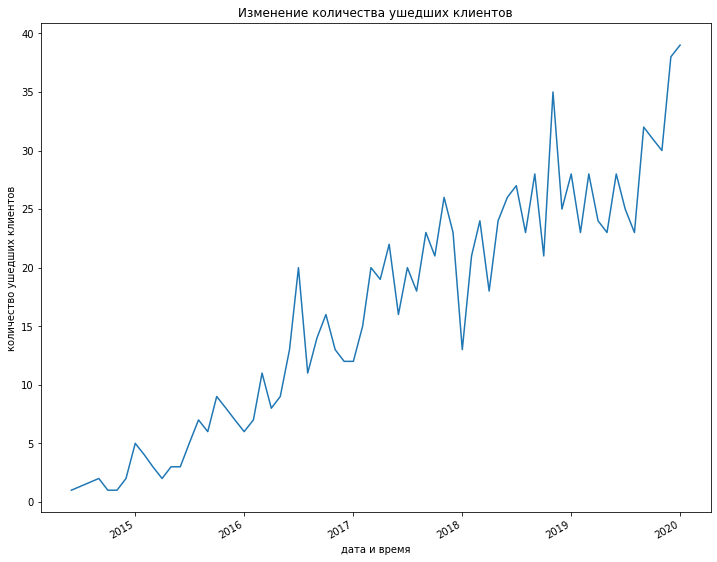

In [49]:
print(ex)
ex.plot(figsize=(12, 10))
plt.xlabel('дата и время')
plt.ylabel('количество ушедших клиентов')
plt.title('Изменение количества ушедших клиентов')
plt.show()

**Вывод:** с каждым годом отток клиентов оператора связи приобретал более массовый характер

In [50]:
data_ex['monthly_charges'].describe()

count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: monthly_charges, dtype: float64

In [51]:
data_stay['monthly_charges'].describe()

count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: monthly_charges, dtype: float64

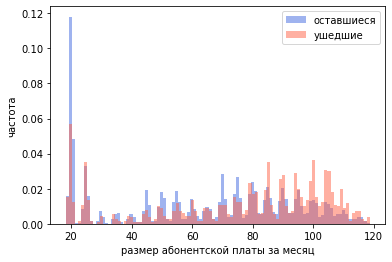

<Figure size 432x648 with 0 Axes>

In [52]:
plt.hist(data_stay['monthly_charges'], alpha = 0.5, bins = 100, color = 'royalblue', density=True, label='оставшиеся')
plt.hist(data_ex['monthly_charges'], alpha = 0.5, bins = 100, color = 'tomato', density=True, label='ушедшие')

plt.title = 'Распределение размера ежемесячных трат на услуги'
plt.xlabel('размер абонентской платы за месяц')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

In [53]:
data_ex['total_charges'].describe()

count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: total_charges, dtype: float64

In [54]:
data_stay['total_charges'].describe()

count    5942.000000
mean     2067.943095
std      2193.827140
min        19.050000
25%       374.352500
50%      1192.800000
75%      3173.837500
max      9221.380000
Name: total_charges, dtype: float64

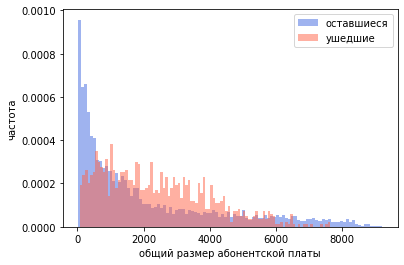

<Figure size 432x648 with 0 Axes>

In [55]:
plt.hist(data_stay['total_charges'], alpha = 0.5, bins = 100, color = 'royalblue', density=True, label='оставшиеся')
plt.hist(data_ex['total_charges'], alpha = 0.5, bins = 100, color = 'tomato', density=True, label='ушедшие')

plt.title = 'Распределение размера общих трат на услуги'
plt.xlabel('общий размер абонентской платы')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

In [56]:
data_ex['amount'].describe()

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: amount, dtype: float64

In [57]:
data_stay['amount'].describe()

count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: amount, dtype: float64

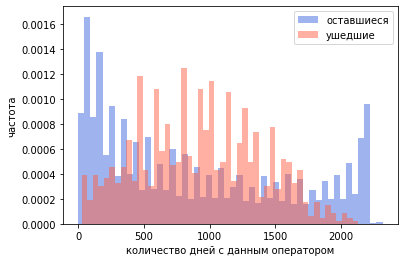

<Figure size 432x648 with 0 Axes>

In [58]:
plt.hist(data_stay['amount'], alpha = 0.5, bins = 50, color = 'royalblue', density=True, label='оставшиеся')
plt.hist(data_ex['amount'], alpha = 0.5, bins = 50, color = 'tomato', density=True, label='ушедшие')

plt.title = 'Распределение количества дней пользования'
plt.xlabel('количество дней с данным оператором')
plt.ylabel('частота')
plt.legend()
plt.figure(figsize=(6, 9))
plt.show()

**Вывод:** на гистограммах можно заметить, что:  
- Распределение ежемесячной абонентской платы схоже, однако, у тех абонентов, которые решили уйти, показатели размера платежа смещены в сторону больших значений. Следует обратить на это внимание;
- Распереление общей суммы выплат по платежам у ушедших абонентов смещено влево, что означает, что среди они не долго пользовались услугами, в отличии от тех, у кого общая сумма успела "набежать";  
- Распределение длительности контакта с оператором связи показывает, что среди оставшихся относительно много новых и старых пользователей, в то время как среди ушедших абонентов в основном были те, кто пользовался услугами среднее количество дней

Далее следует визуализировать качественные признаки для дальнейшего анализа.

In [59]:
def barchart(what):
    aaa = what.value_counts(normalize= True)
    print(aaa)
    aaa.plot(kind='pie', figsize = (5, 5))

Month-to-month    0.369664
Two year          0.346049
One year          0.284287
Name: type, dtype: float64


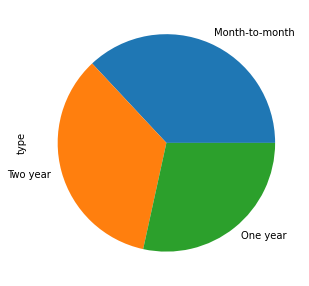

In [60]:
barchart(data_ex['type'])

Month-to-month    0.583642
Two year          0.221138
One year          0.195220
Name: type, dtype: float64


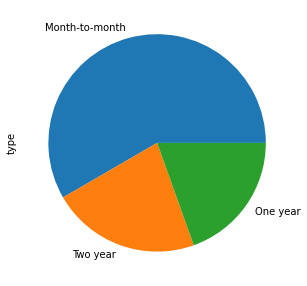

In [61]:
barchart(data_stay['type'])

Yes    0.654859
No     0.345141
Name: paperless_billing, dtype: float64


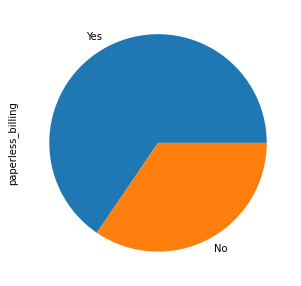

In [62]:
barchart(data_ex['paperless_billing'])

Yes    0.580613
No     0.419387
Name: paperless_billing, dtype: float64


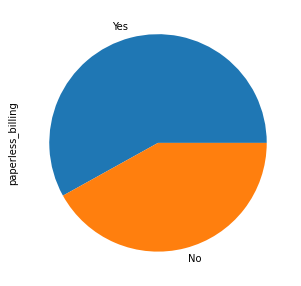

In [63]:
barchart(data_stay['paperless_billing'])

Male      0.520436
Female    0.479564
Name: gender, dtype: float64


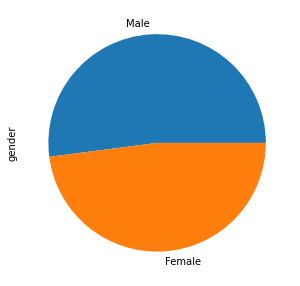

In [64]:
barchart(data_ex['gender'])

Male      0.501851
Female    0.498149
Name: gender, dtype: float64


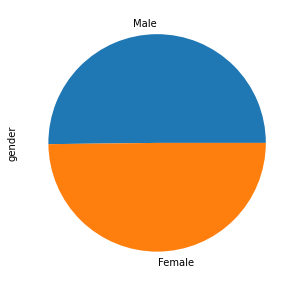

In [65]:
barchart(data_stay['gender'])

0    0.789282
1    0.210718
Name: senior_citizen, dtype: float64


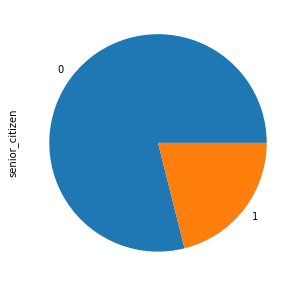

In [66]:
barchart(data_ex['senior_citizen'])

0    0.846853
1    0.153147
Name: senior_citizen, dtype: float64


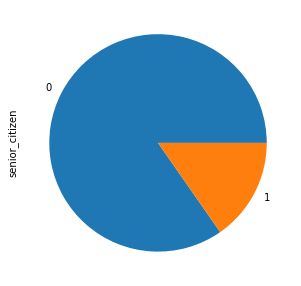

In [67]:
barchart(data_stay['senior_citizen'])

Yes    0.653043
No     0.346957
Name: partner, dtype: float64


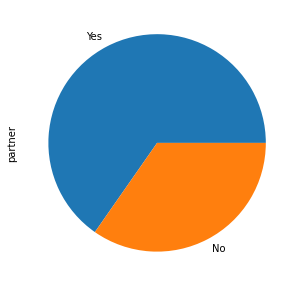

In [68]:
barchart(data_ex['partner'])

No     0.548469
Yes    0.451531
Name: partner, dtype: float64


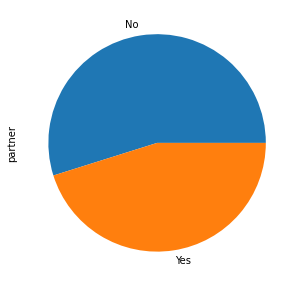

In [69]:
barchart(data_stay['partner'])

Electronic check             0.317893
Bank transfer (automatic)    0.287920
Credit card (automatic)      0.287920
Mailed check                 0.106267
Name: payment_method, dtype: float64


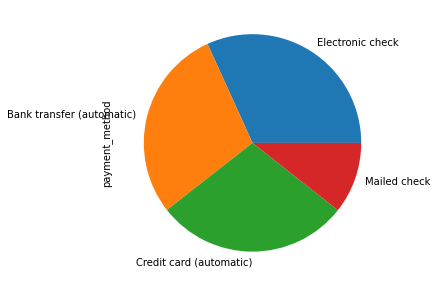

In [70]:
barchart(data_ex['payment_method'])

Electronic check             0.339111
Mailed check                 0.251599
Bank transfer (automatic)    0.206496
Credit card (automatic)      0.202794
Name: payment_method, dtype: float64


/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


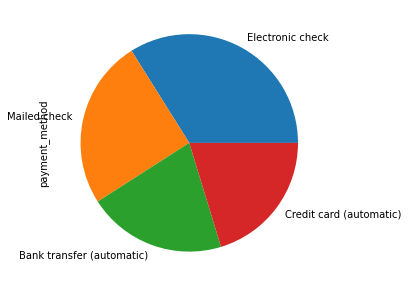

In [71]:
barchart(data_stay['payment_method'])

No     0.665758
Yes    0.334242
Name: dependents, dtype: float64


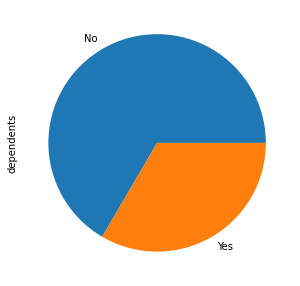

In [72]:
barchart(data_ex['dependents'])

No     0.706833
Yes    0.293167
Name: dependents, dtype: float64


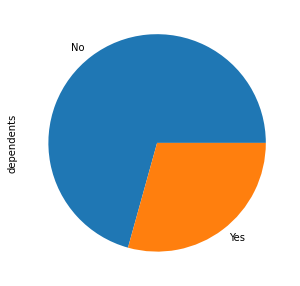

In [73]:
barchart(data_stay['dependents'])

Fiber optic    0.540418
DSL            0.314260
Unknown        0.145322
Name: internet_service, dtype: float64


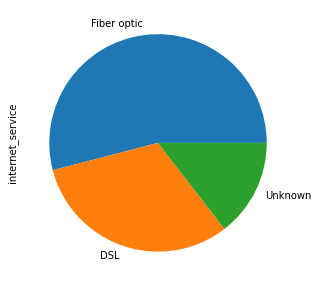

In [74]:
barchart(data_ex['internet_service'])

Fiber optic    0.420902
DSL            0.349209
Unknown        0.229889
Name: internet_service, dtype: float64


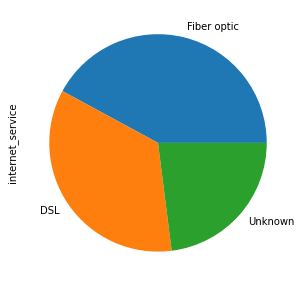

In [75]:
barchart(data_stay['internet_service'])

No         0.477748
Yes        0.376930
Unknown    0.145322
Name: online_security, dtype: float64


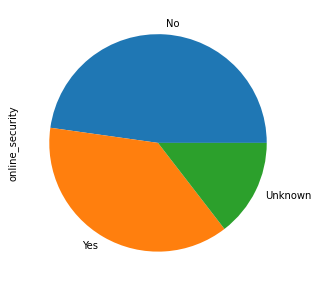

In [76]:
barchart(data_ex['online_security'])

No         0.500168
Yes        0.269943
Unknown    0.229889
Name: online_security, dtype: float64


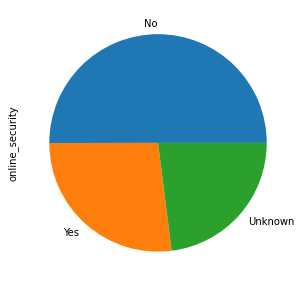

In [77]:
barchart(data_stay['online_security'])

Yes        0.508629
No         0.346049
Unknown    0.145322
Name: online_backup, dtype: float64


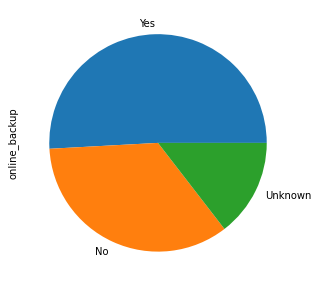

In [78]:
barchart(data_ex['online_backup'])

No         0.455571
Yes        0.314541
Unknown    0.229889
Name: online_backup, dtype: float64


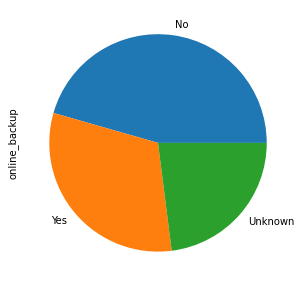

In [79]:
barchart(data_stay['online_backup'])

No         0.455066
Yes        0.315045
Unknown    0.229889
Name: device_protection, dtype: float64


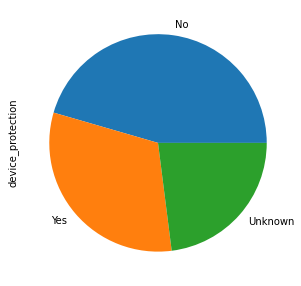

In [80]:
barchart(data_stay['device_protection'])

Yes        0.499546
No         0.355132
Unknown    0.145322
Name: device_protection, dtype: float64


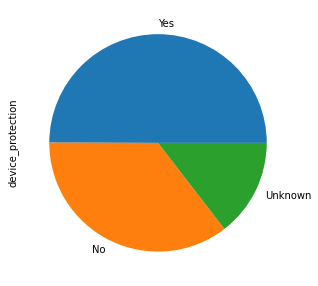

In [81]:
barchart(data_ex['device_protection'])

No         0.493100
Yes        0.277011
Unknown    0.229889
Name: tech_support, dtype: float64


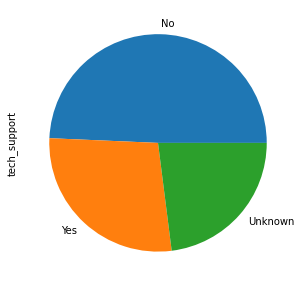

In [82]:
barchart(data_stay['tech_support'])

No         0.493188
Yes        0.361490
Unknown    0.145322
Name: tech_support, dtype: float64


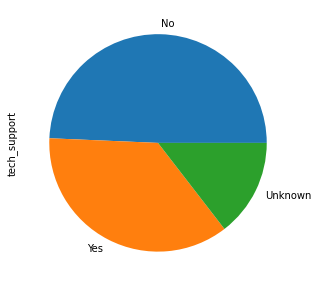

In [83]:
barchart(data_ex['tech_support'])

No         0.412824
Yes        0.357287
Unknown    0.229889
Name: streaming_tv, dtype: float64


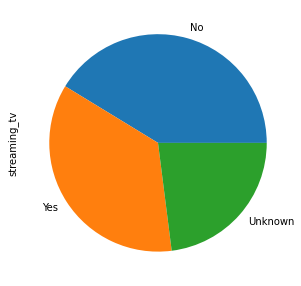

In [84]:
barchart(data_stay['streaming_tv'])

Yes        0.530427
No         0.324251
Unknown    0.145322
Name: streaming_tv, dtype: float64


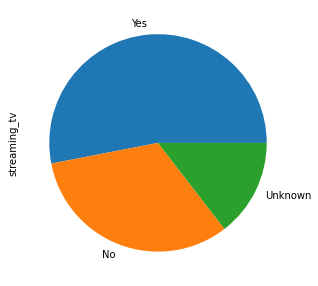

In [85]:
barchart(data_ex['streaming_tv'])

No         0.412319
Yes        0.357792
Unknown    0.229889
Name: streaming_movies, dtype: float64


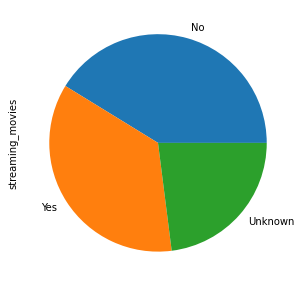

In [86]:
barchart(data_stay['streaming_movies'])

Yes        0.550409
No         0.304269
Unknown    0.145322
Name: streaming_movies, dtype: float64


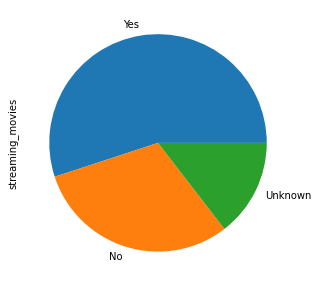

In [87]:
barchart(data_ex['streaming_movies'])

No         0.516661
Yes        0.385897
Unknown    0.097442
Name: multipleLines, dtype: float64


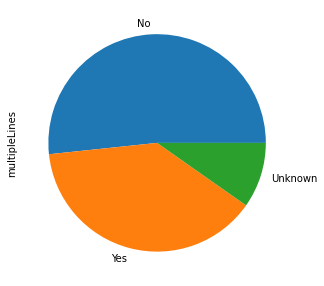

In [88]:
barchart(data_stay['multipleLines'])

Yes        0.615804
No         0.290645
Unknown    0.093551
Name: multipleLines, dtype: float64


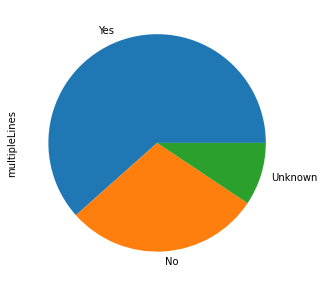

In [89]:
barchart(data_ex['multipleLines'])

Теперь следует отдельно рассмотреть баланс целевого признака.

0    0.843675
1    0.156325
Name: exit, dtype: float64


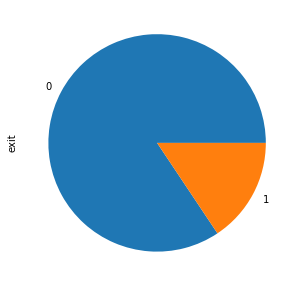

In [90]:
barchart(data['exit'])

**Вывод:** В данном разделе были проанализированы особенности пользовательского поведения ушедших и оставшихся клиентов с помощью визуализации. На основе данных особенностей и различий, можно составить "портрет ушедшего клиента", чтобы опираться на него при разработке стратегий удержания клиентов.  
Таким образом было обнаружено, что в отличии от оставшихся клиентов, ушедшие клиенты:  
- не имеют предпочтительного типа оплаты услуг
- содержат больший процент пенсионеров
- преимущественно клиенты с парой (партнером)
- чаще использовали такие способы оплаты как: автоматический банковский перевод и автоматическую оплаты кредитной картой 
- предпочтитали такой вид интернет-сервиса как Fiber optic (в большей степени, чем DSL)
- чаще пользовались услугой облачного хранилища файлов для резервного копирования данных
- чаще пользовались услугой блокировки небезопасных сайтов
- чаще пользовались услугой стримингового телевидения
- чаще имели каталог фильмов
- чаще имели возможности ведения параллельных линий во время звонка


В то время как оставшиеся клиенты:  
- предпочитают ежемесячный тип оплаты
- преимущественно клиенты без пары
- чаще использовали такие способы оплаты как: электронный чек и отправленный чек
- чаще использовали такой вид интернет-сервиса DSL

Далее следует изучить количественные признаки на предмет мультиколлениарности, а также корреляции с целевым признаком.

<AxesSubplot:>

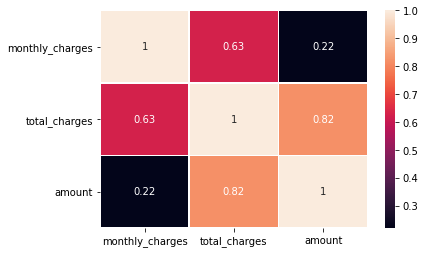

In [91]:
sns.heatmap(contract.drop('exit', axis=1).corr(), linewidths=.5, annot=True)

На матрице видно, что признак 'total_charges' слишком коррелирует с другими признаками, поэтому его следует удалить, как и те признаки, которые напрямую влиют на целевую переменную - даты.

In [92]:
data = data.drop('total_charges', axis = 1)

In [93]:
data = data.drop('begin_date', axis = 1)

In [94]:
data = data.drop('end_date', axis = 1)

Отдельно проверю корреляцию с целевым признаком количественных переменных

In [95]:
data['monthly_charges'].corr(data['exit'])

0.15428642379852728

In [96]:
data['amount'].corr(data['exit'])

0.016578408419946875

#  Подготовка признаков и построение моделей

Прежде, чем преобразовывать данные, следует создать их копию

In [97]:
data_copy = data
data_copy.shape == data.shape

True

In [98]:
data_copy = data_copy.reset_index(drop= True)
data_copy.head()

,type,paperless_billing,payment_method,monthly_charges,amount,exit,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multipleLines
0,Month-to-month,Yes,Electronic check,29.85,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Unknown
1,One year,No,Mailed check,56.95,1036,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,123,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1371,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Unknown
4,Month-to-month,Yes,Electronic check,70.70,153,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Далее я разделю выборки согласно условию проекта

In [99]:
data_train, data_test = train_test_split(data_copy, test_size=0.25, random_state=SEED)

In [100]:
features_train = data_train.drop(columns = ['exit'])
target_train = data_train['exit']

features_test = data_test.drop(columns = ['exit'])
target_test = data_test['exit']

Так как в данных присутствует множество категориальных переменных, следует их преобразовать в количественные релевантным условиям проекта - OneHotEncoder() 

In [101]:
features_categirical = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multipleLines']
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

encoder_ohe.fit(features_train[features_categirical])
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[features_categirical])

features_train = features_train.drop(features_categirical, axis=1)
features_train.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,monthly_charges,amount,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,...,device_protection_Unknown,device_protection_Yes,tech_support_Unknown,tech_support_Yes,streaming_tv_Unknown,streaming_tv_Yes,streaming_movies_Unknown,streaming_movies_Yes,multipleLines_Unknown,multipleLines_Yes
3633,71.25,31,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4718,20.00,610,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1246,105.15,1371,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3155,19.85,883,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4974,36.85,153,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [102]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[features_categirical])

features_test = features_test.drop(features_categirical, axis=1)

features_test.head()

,monthly_charges,amount,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,...,device_protection_Unknown,device_protection_Yes,tech_support_Unknown,tech_support_Yes,streaming_tv_Unknown,streaming_tv_Yes,streaming_movies_Unknown,streaming_movies_Yes,multipleLines_Unknown,multipleLines_Yes
5386,45.80,306,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5573,69.85,62,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,64.80,518,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
337,88.15,2071,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
5752,26.00,2102,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


После того, как категориальные признаки были преобразованы, можно проверить их на предмет мультиколлениарности

In [103]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1 
    return (stat/(obs*mini))

In [104]:
rows= []

for var1 in features_train:
    col = []
    for var2 in features_train:
        cramers =cramers_V(features_train[var1], features_train[var2])
        col.append(round(cramers,2)) 
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns =features_train.columns, index =features_train.columns)

df

,monthly_charges,amount,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,...,device_protection_Unknown,device_protection_Yes,tech_support_Unknown,tech_support_Yes,streaming_tv_Unknown,streaming_tv_Yes,streaming_movies_Unknown,streaming_movies_Yes,multipleLines_Unknown,multipleLines_Yes
monthly_charges,1.00,0.32,0.31,0.35,0.38,0.29,0.36,0.37,0.27,0.35,...,0.95,0.53,0.95,0.47,0.95,0.62,0.95,0.62,0.67,0.58
amount,0.32,1.00,0.14,0.38,0.05,0.11,0.09,0.10,0.04,0.07,...,0.05,0.18,0.05,0.14,0.05,0.13,0.05,0.13,0.04,0.17
type_One year,0.31,0.14,1.00,0.08,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
type_Two year,0.35,0.38,0.08,1.00,0.02,0.03,0.08,0.00,0.00,0.01,...,0.04,0.02,0.04,0.06,0.04,0.00,0.04,0.00,0.00,0.01
paperless_billing_Yes,0.38,0.05,0.00,0.02,1.00,0.00,0.04,0.04,0.00,0.02,...,0.10,0.01,0.10,0.00,0.10,0.05,0.10,0.05,0.00,0.03
payment_method_Credit card (automatic),0.29,0.11,0.00,0.03,0.00,1.00,0.14,0.08,0.00,0.00,...,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
payment_method_Electronic check,0.36,0.09,0.01,0.08,0.04,0.14,1.00,0.15,0.00,0.03,...,0.08,0.00,0.08,0.01,0.08,0.02,0.08,0.02,0.00,0.01
payment_method_Mailed check,0.37,0.10,0.00,0.00,0.04,0.08,0.15,1.00,0.00,0.02,...,0.10,0.04,0.10,0.01,0.10,0.06,0.10,0.06,0.00,0.05
gender_Male,0.27,0.04,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
senior_citizen_1,0.35,0.07,0.00,0.01,0.02,0.00,0.03,0.02,0.00,1.00,...,0.03,0.00,0.03,0.00,0.03,0.01,0.03,0.01,0.00,0.02


/tmp/ipykernel_280/2033311802.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


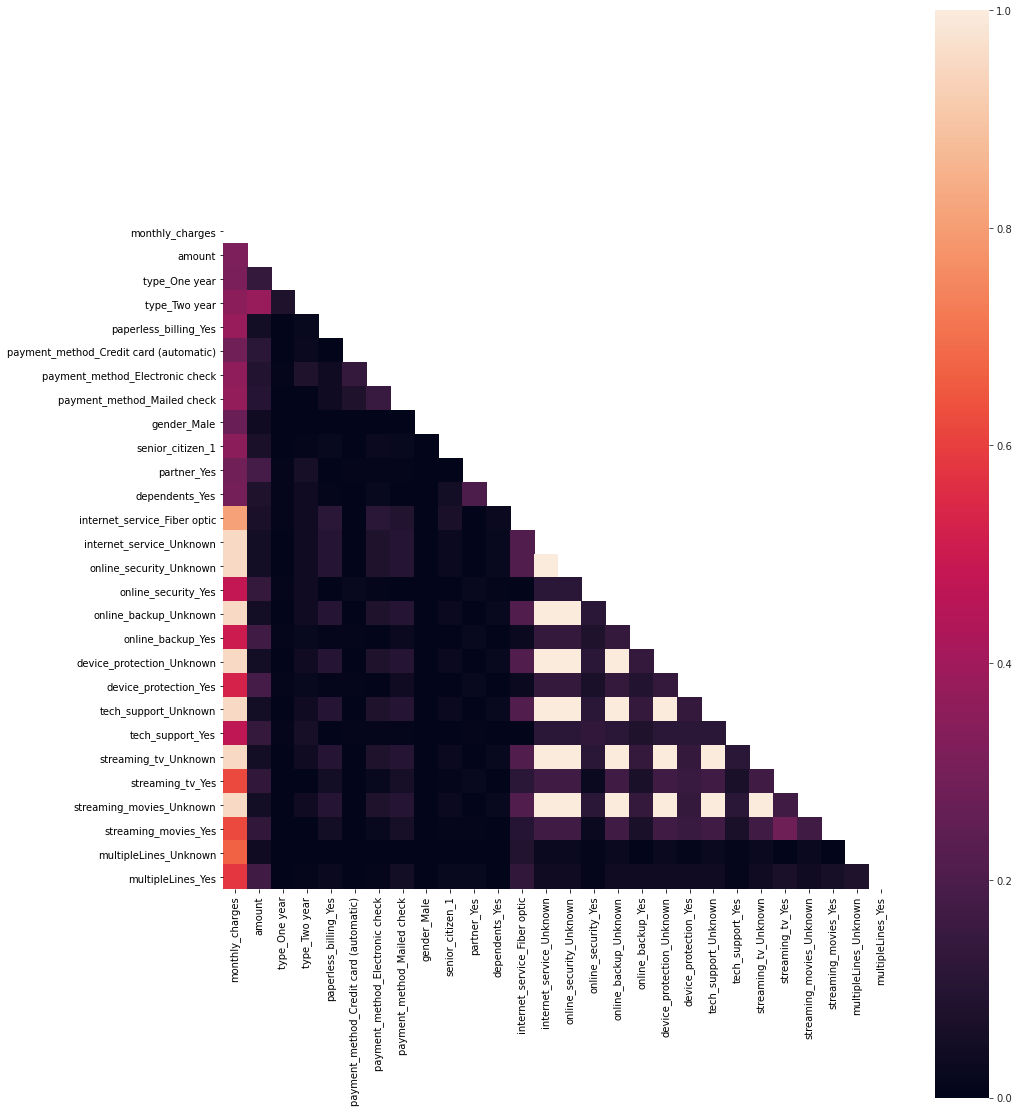

In [105]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 20))
with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

**Вывод:** В ходе анализа корреляции качественных признаков, были выявлены те, что имеют мультиколлениарность, а именно:  
- 'internet_service_Unknown' - неизвестно наличие услуги интернет-сервиса;
- 'online_security_Unknown' - неизвестно наличие услуги блокировки небезопасных сайтов;
- 'online_backup_Unknown' - неизвестно наличие услуги облачное хранилище файлов для резервного копирования данных;
- 'device_protection_Unknown' - неизвестно наличие услуги предоставления антивируса;
- 'tech_support_Unknown' - неизвестно наличие услуги выделенной линии технической поддержки;
- 'streaming_tv_Unknown' - неизвестно наличие услуги стримингового телевидения;
- 'streaming_movies_Unknown' - неизвестно наличие каталога фильмов.

Для улучшения качества предсказаний, их следует удалить.

In [106]:
fff = ['internet_service_Unknown',
       'online_security_Unknown',
       'online_backup_Unknown',
       'device_protection_Unknown',
       'tech_support_Unknown',
       'streaming_tv_Unknown',
       'streaming_movies_Unknown']

In [107]:
features_train = features_train.drop(fff, axis=1)
features_test = features_test.drop(fff, axis=1)

Далее я проверю наличие корреляции с целевым признаком

In [108]:
def cor(aaa):
    return aaa.corr(target_train)

In [109]:
for a in features_train.columns:
    if cor(features_train[a]) > 0.5:
        print(a)

Корреляции категориальных признаков с целевым не обнаружено  
Далее следует преобразовать численные признаки, поскольку в дальнейшем будут использоваться линейные модели, а также масштаб признаков отличается друг от друга

In [110]:
numeric = ['monthly_charges', 'amount']

In [111]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_test.shape)

(5282, 21)
(1761, 21)


In [112]:
features_train

,monthly_charges,amount,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,...,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multipleLines_Unknown,multipleLines_Yes
3633,0.206279,-1.277534,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4718,-1.505055,-0.429388,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,1.338264,0.685360,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3155,-1.510064,-0.029485,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4974,-0.942402,-1.098822,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810,1.274820,0.327938,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
1343,0.266385,1.532041,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2312,-1.501716,-0.518743,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5788,-1.333087,-1.142768,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Наконец, приступим к построению моделей классификации, что удовлетворяет цели проекта

In [113]:
classifiers = [DecisionTreeClassifier(random_state=SEED), 
               RandomForestClassifier(random_state=SEED),
               LogisticRegression(random_state=SEED),
               CatBoostClassifier(random_state=SEED, verbose=False)]

In [114]:
head = 10
for model in classifiers[:head]:
    start = time()
    model.fit(features_train, target_train)
    train_time = time() - start
    start = time()
    pred_train = model.predict(features_train)
    scores = cross_val_score(estimator = model, X=features_train, y=target_train, scoring='roc_auc')
    final_score = sum(scores) / len(scores)
    predict_time = time()-start
    print(model)
    print("\tВремя обучения: %0.3fs" % train_time)
    print("\tВремя предсказания+оценка: %0.3fs" % predict_time)
    print('Средняя оценка качества модели:', final_score)
    print()

DecisionTreeClassifier(random_state=280823)
	Время обучения: 0.047s
	Время предсказания+оценка: 0.219s
Средняя оценка качества модели: 0.6368892781730493

RandomForestClassifier(random_state=280823)
	Время обучения: 0.466s
	Время предсказания+оценка: 2.162s
Средняя оценка качества модели: 0.8078270529290732

LogisticRegression(random_state=280823)
	Время обучения: 0.349s
	Время предсказания+оценка: 1.810s
Средняя оценка качества модели: 0.7599983015169165

	Время обучения: 3.763s
	Время предсказания+оценка: 16.855s
Средняя оценка качества модели: 0.8851654621612667



По результатам предварительного анализа показателей качества моделей, следует обратить внимание на модель CatBoostClassifier() с показателем roc_auc 0.89 , а также модель RandomForestClassifier() с показателем качества 0.8

Однако, этап подбора гиперпараметров должны пройти все модели

In [115]:
parameters_1 = {'depth' : (range(4, 5, 6)),
                'iterations': (range(50, 200, 50)),
                'learning_rate' : [0.05, 0.5, 0.05],
                'random_state': [SEED]
             }

In [116]:
%%time
grid = GridSearchCV(CatBoostClassifier(),parameters_1, scoring='roc_auc', cv = 5, n_jobs=-1)

model = grid.fit(features_train, target_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

0:	learn: 0.6536944	total: 1.87ms	remaining: 91.5ms
1:	learn: 0.6206784	total: 3.19ms	remaining: 76.6ms
2:	learn: 0.5941235	total: 4.4ms	remaining: 69ms
3:	learn: 0.5677991	total: 5.47ms	remaining: 62.9ms
4:	learn: 0.5483417	total: 6.56ms	remaining: 59.1ms
5:	learn: 0.5247309	total: 7.64ms	remaining: 56.1ms
6:	learn: 0.5041727	total: 8.7ms	remaining: 53.4ms
7:	learn: 0.4892139	total: 9.88ms	remaining: 51.9ms
8:	learn: 0.4778701	total: 10.9ms	remaining: 49.7ms
9:	learn: 0.4639041	total: 12.1ms	remaining: 48.3ms
10:	learn: 0.4524731	total: 13.3ms	remaining: 47ms
11:	learn: 0.4401446	total: 14.6ms	remaining: 46.3ms
12:	learn: 0.4313860	total: 15.7ms	remaining: 44.8ms
13:	learn: 0.4257205	total: 16.4ms	remaining: 42.3ms
14:	learn: 0.4181530	total: 17.6ms	remaining: 41ms
15:	learn: 0.4134379	total: 18.7ms	remaining: 39.8ms
16:	learn: 0.4066779	total: 19.8ms	remaining: 38.4ms
17:	learn: 0.4014130	total: 21ms	remaining: 37.4ms
18:	learn: 0.3968898	total: 22.1ms	remaining: 36.1ms
19:	learn: 0.

In [117]:
parameters_2 = {'n_estimators' : (range(10, 100, 10)),
                'max_depth' : (range(1, 7)),
                'random_state': [SEED]
             }

In [118]:
%%time
grid = GridSearchCV(RandomForestClassifier(),parameters_2, scoring='roc_auc', cv = 5, n_jobs=-1)

model = grid.fit(features_train, target_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

{'max_depth': 6, 'n_estimators': 90, 'random_state': 280823} 

0.821258738390006 

CPU times: user 33.2 s, sys: 145 ms, total: 33.3 s
Wall time: 33.6 s


In [119]:
parameters_3 = {'min_samples_split' : (range(2, 100)),
                'max_depth' : (range(1, 7)),
                'random_state': [SEED]
             }

In [120]:
%%time
grid = GridSearchCV(DecisionTreeClassifier(),parameters_3, scoring='roc_auc', cv = 5, n_jobs=-1)

model = grid.fit(features_train, target_train)

print(model.best_params_,'\n')
print(model.best_score_,'\n')

{'max_depth': 6, 'min_samples_split': 86, 'random_state': 280823} 

0.7968017454886868 

CPU times: user 34.8 s, sys: 81.1 ms, total: 34.9 s
Wall time: 35 s


In [121]:
%time
model = LogisticRegression(random_state=SEED).fit(features_train, target_train)
score = cross_val_score(estimator = model, X=features_train, y=target_train, scoring='roc_auc')
final_score = sum(score) / len(score)
final_score

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


0.7599983015169165

**Вывод:** Таким образом, в результате подбора гиперпараметров, модель CatBoostClassifier() удовлетворяет условию заказчика насчет показателя качества и является лучшей моделью с такими гиперпараметрами как {'depth': 4, 'iterations': 150, 'learning_rate': 0.5, 'random_state': 280823}. Остальные модели не преодолели назначенный порог качества модели. Следовательно, для тестирования лучшей модели подойдет модель CatBoostClassifier()

# Тестирование модели

In [122]:
%%time
model = CatBoostClassifier(random_state=SEED, depth = 4, iterations = 150, learning_rate = 0.5)
model.fit(features_train, target_train)

0:	learn: 0.4459132	total: 1.62ms	remaining: 242ms
1:	learn: 0.3779775	total: 3.4ms	remaining: 252ms
2:	learn: 0.3531719	total: 4.87ms	remaining: 239ms
3:	learn: 0.3403440	total: 6.22ms	remaining: 227ms
4:	learn: 0.3330172	total: 7.62ms	remaining: 221ms
5:	learn: 0.3278127	total: 9ms	remaining: 216ms
6:	learn: 0.3246975	total: 10.4ms	remaining: 212ms
7:	learn: 0.3211053	total: 11.7ms	remaining: 207ms
8:	learn: 0.3180483	total: 13ms	remaining: 204ms
9:	learn: 0.3163886	total: 14.3ms	remaining: 201ms
10:	learn: 0.3144953	total: 15.8ms	remaining: 200ms
11:	learn: 0.3128083	total: 17.2ms	remaining: 198ms
12:	learn: 0.3097206	total: 18.6ms	remaining: 197ms
13:	learn: 0.3057127	total: 20.1ms	remaining: 195ms
14:	learn: 0.3010300	total: 21.4ms	remaining: 192ms
15:	learn: 0.2964872	total: 22.8ms	remaining: 191ms
16:	learn: 0.2943922	total: 24.1ms	remaining: 189ms
17:	learn: 0.2908023	total: 25.5ms	remaining: 187ms
18:	learn: 0.2865346	total: 27ms	remaining: 186ms
19:	learn: 0.2849223	total: 28

In [123]:
preds_proba = model.predict_proba(features_test)

In [124]:
roc_auc_score(target_test, preds_proba[:, 1])

0.9255547320381549

На данном этапе я произведу анализ важности признаков для обучения

0:	learn: 0.4459132	total: 1.88ms	remaining: 279ms
1:	learn: 0.3779775	total: 3.8ms	remaining: 281ms
2:	learn: 0.3531719	total: 5.4ms	remaining: 265ms
3:	learn: 0.3403440	total: 6.95ms	remaining: 254ms
4:	learn: 0.3330172	total: 8.38ms	remaining: 243ms
5:	learn: 0.3278127	total: 9.93ms	remaining: 238ms
6:	learn: 0.3246975	total: 11.3ms	remaining: 231ms
7:	learn: 0.3211053	total: 12.9ms	remaining: 229ms
8:	learn: 0.3180483	total: 14.2ms	remaining: 222ms
9:	learn: 0.3163886	total: 15.5ms	remaining: 217ms
10:	learn: 0.3144953	total: 17ms	remaining: 214ms
11:	learn: 0.3128083	total: 18.3ms	remaining: 210ms
12:	learn: 0.3097206	total: 19.8ms	remaining: 208ms
13:	learn: 0.3057127	total: 21.1ms	remaining: 205ms
14:	learn: 0.3010300	total: 22.6ms	remaining: 203ms
15:	learn: 0.2964872	total: 24.1ms	remaining: 201ms
16:	learn: 0.2943922	total: 25.5ms	remaining: 199ms
17:	learn: 0.2908023	total: 26.9ms	remaining: 197ms
18:	learn: 0.2865346	total: 28.4ms	remaining: 196ms
19:	learn: 0.2849223	total

<AxesSubplot:>

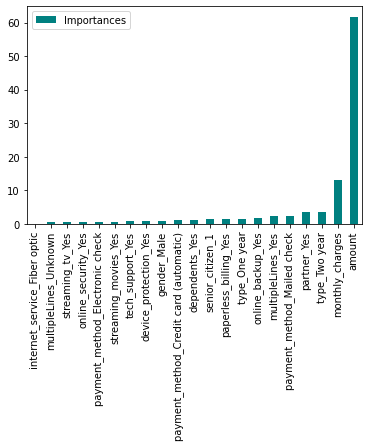

In [125]:
model = CatBoostClassifier(random_state=SEED, depth = 4, iterations = 150, learning_rate = 0.5)
model.fit(features_train, target_train)

importances = model.feature_importances_
final_df = pd.DataFrame({"Features" : pd.DataFrame(features_train).columns, "Importances" : importances}, index = features_train.columns)
final_df.set_index('Importances')
final_df = final_df.sort_values('Importances')
final_df.plot.bar(color = 'teal')

Далее я построю матрицу ошибок для более детального анализа модели

In [126]:
pred = np.argmax(preds_proba, axis=1)

Text(33.0, 0.5, 'True')

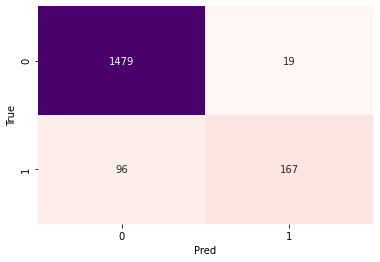

In [127]:
aaa = sns.heatmap(confusion_matrix(target_test, pred), annot=True, fmt='d', cmap="RdPu", cbar=False)
aaa.set_xlabel('Pred')
aaa.set_ylabel('True')

Таким образом, лучшая выбранная модель дает преимущественное количество истинно верных ответов

In [128]:
def get_fp_tp(y, proba, threshold):
    pred = pd.Series(np.where(proba>=threshold, 1, 0),
                     dtype='category')
    pred.cat.set_categories([0,1], inplace=True)
    confusion_matrix = pred.groupby([y, pred]).size().unstack()\
                           .rename(columns={0: 'pred_0',
                                        1: 'pred_1'},
                                   index={0: 'actual_0',
                                          1: 'actual_1'})
    false_positives = confusion_matrix.loc['actual_0', 'pred_1']
    true_positives = confusion_matrix.loc['actual_1', 'pred_1']
    return false_positives, true_positives

0:	learn: 0.4459132	total: 1.6ms	remaining: 238ms
1:	learn: 0.3779775	total: 3.23ms	remaining: 239ms
2:	learn: 0.3531719	total: 4.83ms	remaining: 237ms
3:	learn: 0.3403440	total: 6.46ms	remaining: 236ms
4:	learn: 0.3330172	total: 7.96ms	remaining: 231ms
5:	learn: 0.3278127	total: 9.36ms	remaining: 225ms
6:	learn: 0.3246975	total: 10.9ms	remaining: 223ms
7:	learn: 0.3211053	total: 12.3ms	remaining: 218ms
8:	learn: 0.3180483	total: 13.7ms	remaining: 215ms
9:	learn: 0.3163886	total: 15.2ms	remaining: 213ms
10:	learn: 0.3144953	total: 16.7ms	remaining: 211ms
11:	learn: 0.3128083	total: 18.3ms	remaining: 210ms
12:	learn: 0.3097206	total: 19.9ms	remaining: 210ms
13:	learn: 0.3057127	total: 21.5ms	remaining: 208ms
14:	learn: 0.3010300	total: 22.9ms	remaining: 206ms
15:	learn: 0.2964872	total: 24.4ms	remaining: 205ms
16:	learn: 0.2943922	total: 26ms	remaining: 203ms
17:	learn: 0.2908023	total: 27.6ms	remaining: 202ms
18:	learn: 0.2865346	total: 29ms	remaining: 200ms
19:	learn: 0.2849223	total:

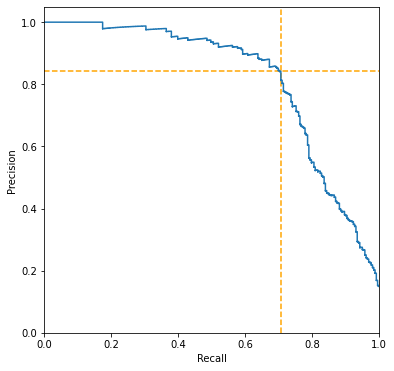

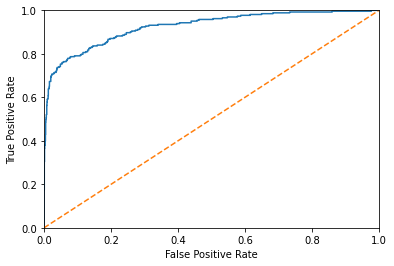

In [129]:
model = CatBoostClassifier(random_state=SEED, depth = 4, iterations = 150, learning_rate = 0.5)
model.fit(features_train, target_train)
probabilities_val = model.predict_proba(features_test)
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_val[:, 1])
fscores = np.divide((2 * precision * recall)
                        , (precision + recall)
                        , where=(precision + recall)!=0)


optimal_idx = np.argmax(fscores)

print(f'Оптимальное значение thresholds: {thresholds[optimal_idx]:.2f}')
print(f'Оптимальное значение f1 на валидационной выборке: {np.max(fscores):.2f}')

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.vlines(recall[optimal_idx], ymin=0, ymax=1.05, linestyles='--', color='orange')
plt.hlines(precision[optimal_idx], xmin=0, xmax=1, linestyles='--', color='orange')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title = 'Кривая Precision-Recall при thresholds'
plt.show()

probabilities_one_valid = probabilities_val[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title = 'ROC-кривая'
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Финальный отчет по проекту

Целью проекта являлась разработка модели классификации с гиперпараметрами, отвечающие требованию по метрикам качества заказчика, для прогноза оттока клиентов.

В ходе проекта были выделены следующие основные шаги, что соответствует изначально разработанному плану:  
1. Первичное знакомство с данными
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка признаков
5. Построение моделей
6. Тестирование лучшей модели

В начале работ некоторые пункты из плана были неверно соотнесены с основными шагами. Однако, в ходе поэтапного анализа были внесены некоторые корректировки:  
- анализ категориальных признаков был произведен после горячего кодирования
- анализ важности признаков был отнесен к лучшей модели при тестировании, а не до подбора гиперпараметров  

Кроме этих, остальные пункты плана были реализованы полностью и в задуманном порядке

Согласно плану, была произведена предобработка признаков:  
- изменены их названия
- изменены типы признаков "begin_date", "end_date" и 'total_charges'
- заполнены неявные пропуски в признаке "total_charges" размером ежемесячной платы, поскольку пользователи ещё не успели заплатить
- добавлен новый признак "длительность контракта"
- 4 исходные таблицы были объединены в одну
- были заполнены образованные пропуски значением unknown

Кроме того, на этапе подготовки признаков:
- было проведено кодирование категориальных признаков
- было проведено масштабирование

В ходе анализа на мультиколлениарность количественных и качественных признаков, а также тех, что связаны с целевым признаком было принято решение удалить следующие признаки для улучшения качества модели:  
- 'begin_date' - дата начала пользования услугами;
- 'end_date' - дата окончания пользования услугами;
- 'total_charges' - всего потрачено денег на услуги;
- 'internet_service_Unknown' - неизвестно наличие услуги интернет-сервиса;
- 'online_security_Unknown' - неизвестно наличие услуги блокировки небезопасных сайтов;
- 'online_backup_Unknown' - неизвестно наличие услуги облачное хранилище файлов для резервного копирования данных;
- 'device_protection_Unknown' - неизвестно наличие услуги предоставления антивируса;
- 'tech_support_Unknown' - неизвестно наличие услуги выделенной линии технической поддержки;
- 'streaming_tv_Unknown' - неизвестно наличие услуги стримингового телевидения;
- 'streaming_movies_Unknown' - неизвестно наличие каталога фильмов.

Таким образом, модель обучалась на оставшихся признаках:  
Обработаны масштабированием:
- 'monthly_charges' - размер ежемесячной платы клиента
- 'amount' - количество дней с данным оператором связи

Обработаны горячим кодированием:
- 'type_One year' - тип платежа (раз в год)
- 'type_Two year' - тип платежа (раз в два года)
- 'paperless_billing_Yes' - наличие электронного платежного чека
- 'payment_method_Credit card (automatic)' - выбор кредитной карты как способа оплаты
- 'payment_method_Electronic check' - выбор электронного чека как способа оплаты
- 'payment_method_Mailed check' - выбор отправленного чека как способа оплаты
- 'gender_Male' - мужской пол 
- 'senior_citizen_1' - отношение к пенсионному возрасту
- 'partner_Yes' - наличие партнера
- 'dependents_Yes' - наличие инживенцев
- 'internet_service_Fiber optic' - вид интернет-сервиса как Fiber optic 
- 'online_security_Yes' - наличие блокировки подозрительных сайтов
- 'online_backup_Yes' -  наличие услуги облачное хранилище файлов для резервного копирования данных
- 'device_protection_Yes' - наличие услуги предоставления антивируса
- 'tech_support_Yes' - наличие услуги выделенной линии технической поддержки
- 'streaming_tv_Yes' - наличие стримингового тв
- 'streaming_movies_Yes' - наличие каталога фильмов
- 'multipleLines_Unknown' - неизвестность наличия возможности ведения параллельных линий во время звонка
- 'multipleLines_Yes' - наличие возможности ведения параллельных линий во время звонка.

По итогам подбора гиперпараметров моделей классификации DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, CatBoostClassifier была выбрана модель CatBoostClassifier с показателем качества auc_roc 0.8851654621612667. После подбора гиперпараметров модель CatBoostClassifier также осталась лучшей - показатель качества при гиперпараметрах: {'depth': 4, 'iterations': 150, 'learning_rate': 0.5, 'random_state': 280823} стал 0.9124281619673358 . Также анализ матрицы ошибок показал, что большинство ответов положительно верные.